In [1]:
from interpretable_ml_kit import get_german_credit_data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report, roc_curve, roc_auc_score

# Import, Preprocess, and Explore the German Credit Dataset

In [2]:
germanCreditData = get_german_credit_data()
germanCreditData.shape

(1000, 54)

In [3]:
germanCreditData.isna().sum().sum()

0

In [4]:
germanCreditData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 54 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   creditDuration             1000 non-null   int64 
 1   creditAmount               1000 non-null   int64 
 2   installmentRate            1000 non-null   int64 
 3   residenceTime              1000 non-null   int64 
 4   Age                        1000 non-null   int64 
 5   numberOfCredit             1000 non-null   int64 
 6   NumberLiablePeople         1000 non-null   int64 
 7   creditRisk                 1000 non-null   int64 
 8   accountStatus_1            1000 non-null   uint8 
 9   creditHistory_A30          1000 non-null   uint8 
 10  creditHistory_A31          1000 non-null   uint8 
 11  creditHistory_A32          1000 non-null   uint8 
 12  creditHistory_A33          1000 non-null   uint8 
 13  creditHistory_A34          1000 non-null   uint8 
 14  Purpose_A

In [5]:
germanCreditData.head()

,creditDuration,creditAmount,installmentRate,residenceTime,Age,numberOfCredit,NumberLiablePeople,creditRisk,accountStatus_1,creditHistory_A30,...,Housing_A151,Housing_A152,Housing_A153,Job_A171,Job_A172,Job_A173,Job_A174,Telephone,foreignWorker_A201,gender
0,6,1169,4,4,67,2,1,1,1,0,...,0,1,0,0,0,1,0,0,1,0
1,48,5951,2,2,22,1,1,0,1,0,...,0,1,0,0,0,1,0,1,1,1
2,12,2096,2,3,49,1,2,1,0,0,...,0,1,0,0,1,0,0,1,1,0
3,42,7882,2,4,45,1,2,1,1,0,...,0,0,1,0,0,1,0,1,1,0
4,24,4870,3,4,53,2,2,0,1,0,...,0,0,1,0,0,1,0,1,1,0


# Decision Tree as a Benchmark

#### Get Features & Response Variable

In [6]:
x = germanCreditData.drop(["creditRisk"], axis=1)
y = germanCreditData["creditRisk"]

#### Fit the Model

In [7]:
model_fit = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy', 
                                   max_depth=8, max_features='auto', max_leaf_nodes=None, 
                                   min_impurity_decrease=0.0, min_impurity_split=None, 
                                   min_samples_leaf=9, min_samples_split=9,
                                   min_weight_fraction_leaf=0.0, 
                                   # presort='deprecated',
                                   random_state=42, splitter='best').fit(x, y)

#### Make Predictions

In [8]:
predictions = model_fit.predict(x)
predictionTree = predictions.copy()

In [10]:
proba_Tree = []

for probs in model_fit.predict_proba(x):
    proba_Tree.append(probs[1])
    
proba_Tree = pd.DataFrame([proba_Tree]).transpose()
proba_Tree.columns= ["S"]

In [11]:
proba_Tree

,S
0,0.857143
1,0.111111
2,1.000000
3,0.500000
4,0.333333
...,...
995,0.666667
996,0.500000
997,0.942308
998,0.111111


#### Compute Accuracy & AUC

In [10]:
confusion_matrix(y,predictionTree)

sumDiagonal=0
for j in range(0,2):
    sumDiagonal += confusion_matrix(y,predictionTree)[j][j]

accuracy = round( (sumDiagonal / proba_Tree.shape[0])*100,2)
print("Accuracy Rate:", accuracy, "%")

Accuracy Rate: 75.7 %


In [12]:
AUCTree = roc_auc_score(y,proba_Tree)
print("AUC :", round(AUCTree, 4))

AUC : 0.8032


#### Feature Sorted by Importance

In [13]:
features_importance = zip(x.columns, model_fit.feature_importances_)
features_importance = sorted(features_importance, key = lambda x: x[1], reverse=True)

In [14]:
for feature, score in features_importance:
    print(f"Feature: {feature:<30} Score: {score:.5f}")

Feature: creditDuration                 Score: 0.20970
Feature: accountStatus_1                Score: 0.19910
Feature: Savings_A61                    Score: 0.12665
Feature: Telephone                      Score: 0.07766
Feature: Property_A121                  Score: 0.05002
Feature: Age                            Score: 0.04447
Feature: creditHistory_A31              Score: 0.04265
Feature: installmentRate                Score: 0.02927
Feature: Purpose_A40                    Score: 0.02511
Feature: Savings_A64                    Score: 0.02497
Feature: Guarantor_A103                 Score: 0.02014
Feature: Job_A173                       Score: 0.01943
Feature: NumberLiablePeople             Score: 0.01608
Feature: Property_A123                  Score: 0.01529
Feature: employmentDuration_A72         Score: 0.01327
Feature: creditAmount                   Score: 0.01203
Feature: gender                         Score: 0.01121
Feature: creditHistory_A32              Score: 0.00913
Feature: H

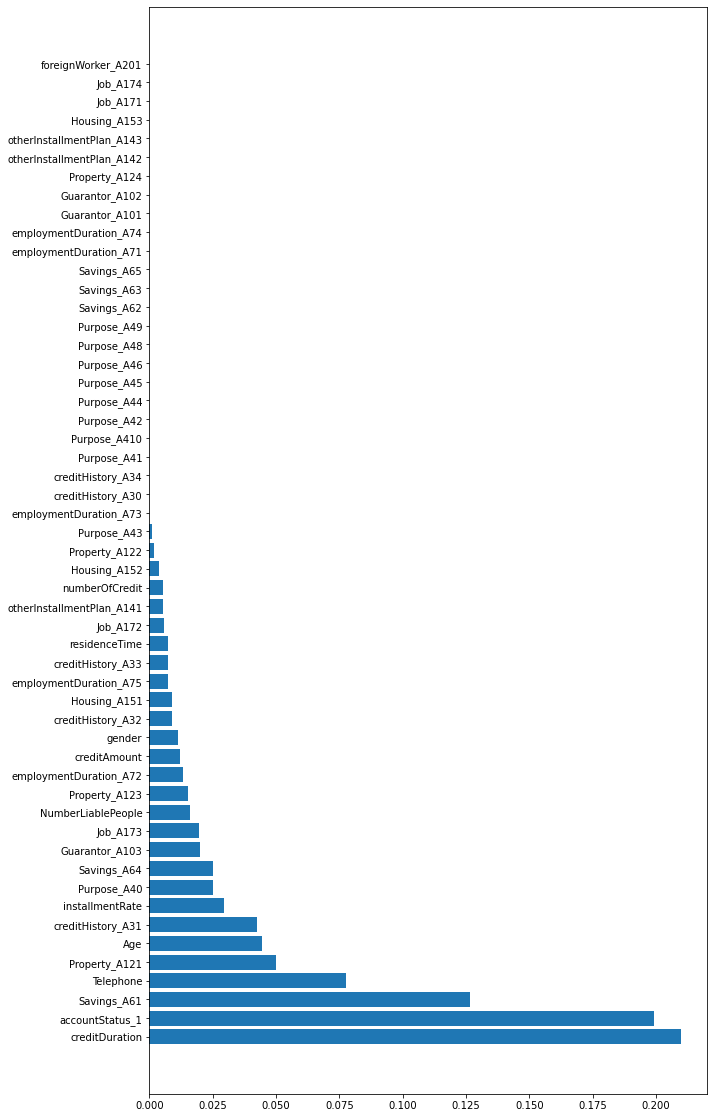

In [15]:
plt.rcParams['figure.figsize'] = [10, 20]

features, importance_score = zip(*features_importance)

plt.barh(features, importance_score)
plt.show()

# Partial Dependence Plot

In [53]:
def _infer_feature_type(feature, X):
    """Test if feature exists and infer its type
    
    Parameters
    ----------
    feature: string or list
        list for one-hot encoded feature
    X: DataFrame
    
    Returns
    -------
    Feature types:
        1. binary
        2. onehot
        3. numeric
    """
    if type(feature) == list:
        if len(feature) < 2: 
            raise ValueError('one-hot encoded feature should contain at least 2 elements')
        if not (set(feature) < set(X.columns.values)):
            raise ValueError(f"feature does not exist: {feature}")
        feature_type = 'onehot'
    else:
        if feature not in X.columns.values:
            raise ValueError(f"feature does not exist: {feature}")
        if sorted(list(np.unique(X[feature]))) == [0, 1]:
            feature_type = 'binary'
        else:
            feature_type = 'numeric'
    return feature_type

In [426]:
def pdp(estimator, X, reference_feature, grid_resolution=50):
    """Generate Partial Dependence Plot
    
    Parameters
    ----------
    estimator: A fitted estimator object implementing `predict_proba`
    reference_feature: string or list
        Which feature is calculated on, list for one-hot encoded feature
    grid_resolution: int, default=50
        The number of equally spaced points on the x-axis of the plot
    
    Returns
    -------
    display : matplotlib plot
    """
    feature_type = _infer_feature_type(reference_feature, X)
    pdp_average_prediction_prob = []
    if feature_type == "numeric":
        rf_min = X[reference_feature].min()
        rf_max = X[reference_feature].max()
        grid = np.linspace(rf_min, rf_max, num=grid_resolution, endpoint=True)
        for i in grid:
            pdp_df = X.copy()
            pdp_df[reference_feature] = i
            pdp_predictions = estimator.predict_proba(pdp_df)[:, 1]
            pdp_average_prediction_prob.append(pdp_predictions.mean())
        plt.rcParams['figure.figsize'] = [5, 5]
        plt.plot(grid, pdp_average_prediction_prob)
        plt.show()
    elif feature_type == "onehot":
        for main_label in reference_feature:
            pdp_df = X.copy()
            other_labels = set(reference_feature) -  set([main_label]) 
            pdp_df[main_label] = 1
            pdp_df[list(other_labels)] = 0
            pdp_predictions = estimator.predict_proba(pdp_df)[:, 1]
            pdp_average_prediction_prob.append(pdp_predictions.mean())
        plt.rcParams['figure.figsize'] = [10, 5]
        plt.plot(reference_feature, pdp_average_prediction_prob)
        plt.show()
    else:
        for i in range(2):
            pdp_df = X.copy()
            pdp_df[reference_feature] = i
            pdp_predictions = estimator.predict_proba(pdp_df)[:, 1]
            pdp_average_prediction_prob.append(pdp_predictions.mean())
        plt.rcParams['figure.figsize'] = [5, 5]
        plt.plot(["0", "1"], pdp_average_prediction_prob)
        plt.show()     

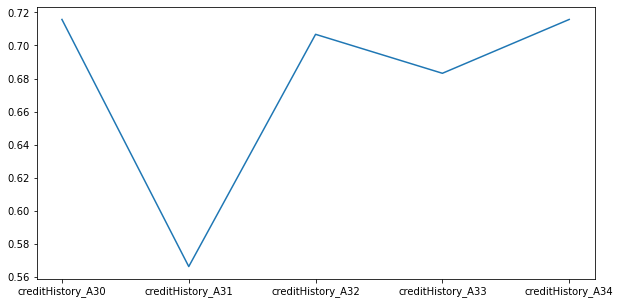

In [427]:
pdp(model_fit, x, [s for s in x.columns if s.startswith('creditHistory')])

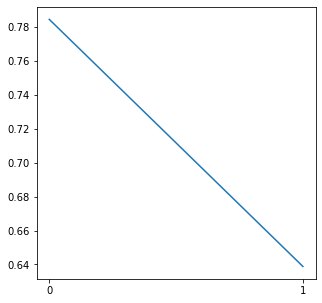

In [428]:
pdp(model_fit, x, "accountStatus_1")

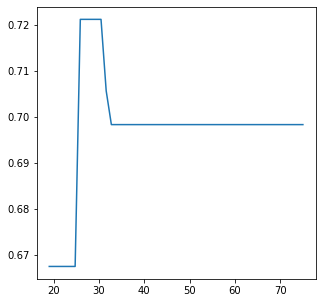

In [429]:
pdp(model_fit, x, "Age", grid_resolution=50)

#### Double check from sklearn

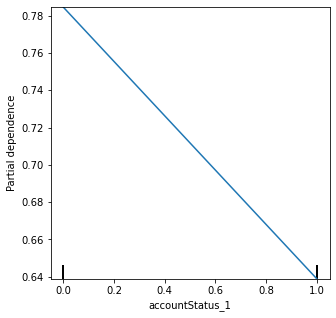

In [163]:
from sklearn.inspection import plot_partial_dependence
plot_partial_dependence(model_fit, x, features=(7,))

# Individual Conditional Expectation

In [420]:
def ice(estimator, X, reference_feature, grid_resolution=50):
    """Generate Individual Conditional Expectation Plot
    
    Parameters
    ----------
    estimator: A fitted estimator object implementing `predict_proba`
    reference_feature: string or list
        Which feature is calculated on, list for one-hot encoded feature
    grid_resolution: int, default=50
        The number of equally spaced points on the x-axis of the plot. 
        Used only if the reference feature is numeric
    
    Returns
    -------
    display : matplotlib plot
    """
    feature_type = _infer_feature_type(reference_feature, X)
    ice_prediction_prob = []
    if feature_type == "numeric":
        rf_min = X[reference_feature].min()
        rf_max = X[reference_feature].max()
        grid = np.linspace(rf_min, rf_max, num=grid_resolution, endpoint=True)
        for i in grid:
            ice_df = X.copy()
            ice_df[reference_feature] = i
            ice_predictions = estimator.predict_proba(ice_df)[:, 1]
            ice_prediction_prob.append(ice_predictions)
        ice_prediction_prob = np.stack(ice_prediction_prob).T # shape: (nrows, grid_resolution)
        plt.rcParams['figure.figsize'] = [5, 5]
        for i in range(x.shape[0]):
            plt.plot(grid, ice_prediction_prob[i,], color="C0", linewidth=0.5)
        plt.show()
    elif feature_type == "onehot":
        for main_label in reference_feature:
            ice_df = X.copy()
            other_labels = set(reference_feature) -  set([main_label]) 
            ice_df[main_label] = 1
            ice_df[list(other_labels)] = 0
            ice_predictions = estimator.predict_proba(ice_df)[:, 1]
            ice_prediction_prob.append(ice_predictions)
        ice_prediction_prob = np.stack(ice_prediction_prob).T
        plt.rcParams['figure.figsize'] = [10, 5]
        for i in range(x.shape[0]):
            plt.plot(reference_feature, ice_prediction_prob[i,], color="C0", linewidth=0.5)
        plt.show()
    else:
        for i in range(2):
            ice_df = X.copy()
            ice_df[reference_feature] = i
            ice_predictions = estimator.predict_proba(ice_df)[:, 1]
            ice_prediction_prob.append(ice_predictions)
        ice_prediction_prob = np.stack(ice_prediction_prob).T
        plt.rcParams['figure.figsize'] = [5, 5]
        for i in range(x.shape[0]):
            plt.plot(["0", "1"], ice_prediction_prob[i,], color="C0", linewidth=0.5)
        plt.show()

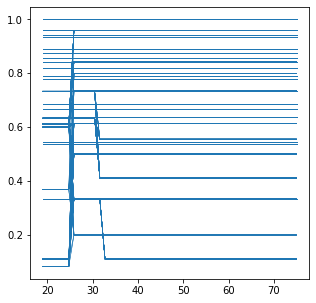

In [421]:
ice(model_fit, x, "Age", grid_resolution=50)

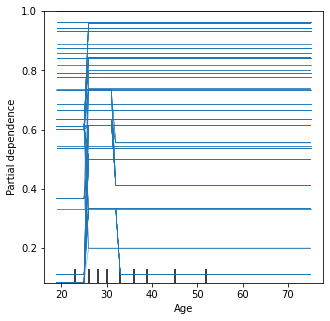

In [422]:
plot_partial_dependence(model_fit, x, features=(4,), kind="individual", subsample=None)

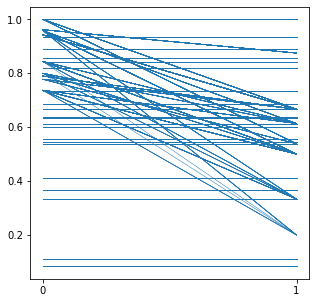

In [423]:
ice(model_fit, x, "accountStatus_1")

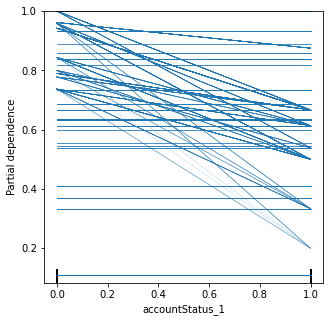

In [424]:
plot_partial_dependence(model_fit, x, features=(7,), kind="individual", subsample=None)

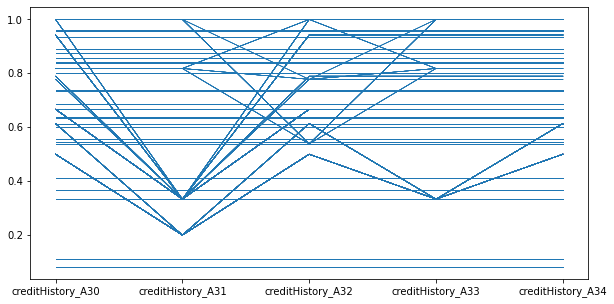

In [425]:
ice(model_fit, x, [s for s in x.columns if s.startswith('creditHistory')])

# Accumulated Local Effects

In [403]:
def ale(estimator, X, reference_feature, bins=10):
    """Generate Accumulated Local Effects Plot
    
    Parameters
    ----------
    estimator: A fitted estimator object implementing `predict_proba`
    reference_feature: string or list
        Which feature is calculated on, list for one-hot encoded feature
    bins: int, default=50
        The number of quantiles is calculated as (bins + 1). 
        Used only if the reference feature is numeric
    
    Returns
    -------
    display : matplotlib plot
    """
    feature_type = _infer_feature_type(reference_feature, X)
    if feature_type == "numeric":
        quantiles = np.unique(np.quantile(X[reference_feature], q = np.linspace(0, 1, bins + 1), interpolation="lower"))
        # -1 to start counting from 0
        # np.clip ensure min age to be assigned to 0 not -1
        indices = np.clip(np.digitize(X[reference_feature], quantiles, right=True) - 1, 0, None)
        ale = np.zeros(bins)
        bins_sample_size = np.zeros(bins)
        for i in range(bins):
            x_subset = X[indices == i]
            subset_size = x_subset.shape[0]
            if (subset_size > 0):
                x_upper = x_subset.copy()
                x_lower = x_subset.copy()
                x_upper[reference_feature] = quantiles[i + 1]
                x_lower[reference_feature] = quantiles[i]
                individual_effect = estimator.predict_proba(x_upper)[:, 1] - estimator.predict_proba(x_lower)[:, 1] 
                ale[i] = individual_effect.mean()
                bins_sample_size[i] = subset_size
        ale = np.array([0, *ale.cumsum()])
        ale = (ale[1:] + ale[:-1]) / 2
        ale -= np.sum(ale * bins_sample_size) / X.shape[0]
        quantiles = (quantiles[1:] + quantiles[:-1]) / 2
        plt.rcParams['figure.figsize'] = [5, 5]
        plt.plot(quantiles, ale)
        plt.show()
    elif feature_type == "onehot":
        num_cat = len(reference_feature)
        ale = np.zeros(num_cat)
        sample_size = np.zeros(num_cat)
        for i in range(num_cat):
            main_feature = reference_feature[i]
            neighbor_feature = reference_feature[i - 1]
            x_subset = X[X[main_feature] == 1]
            subset_size = x_subset.shape[0]
            if (subset_size > 0):
                x_lower = x_subset.copy()
                x_lower[main_feature] = 0
                x_lower[neighbor_feature] = 1
                individual_effect = estimator.predict_proba(x_subset)[:, 1] - estimator.predict_proba(x_lower)[:, 1] 
                ale[i] = individual_effect.mean()
                sample_size[i] = subset_size
        ale = ale.cumsum()
        ale -= np.sum(ale * sample_size) / X.shape[0]
        plt.rcParams['figure.figsize'] = [10, 5]
        plt.plot(reference_feature, ale)
        plt.show()
    else:
        ale = np.zeros(2)
        sample_size = np.zeros(2)
        for i in range(2):
            x_subset = X[X[reference_feature] == i]
            subset_size = x_subset.shape[0]
            if (subset_size > 0):
                x_neighbor = x_subset.copy()
                x_neighbor[reference_feature] = (1 - i)
                individual_effect = estimator.predict_proba(x_subset)[:, 1] - estimator.predict_proba(x_neighbor)[:, 1] 
                ale[i] = individual_effect.mean()
                sample_size[i] = subset_size
        ale = ale.cumsum()
        ale -= np.sum(ale * sample_size) / X.shape[0]
        plt.rcParams['figure.figsize'] = [5, 5]
        plt.plot(["0", "1"], ale)
        plt.show()

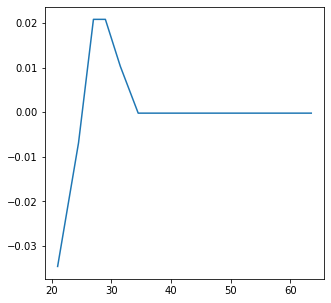

In [404]:
ale(model_fit, x, "Age", bins=10)

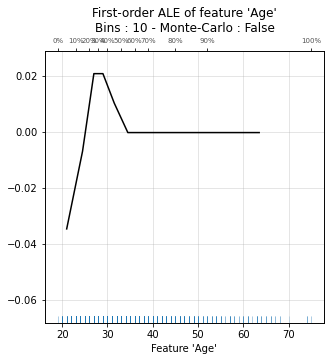

<AxesSubplot:title={'center':"First-order ALE of feature 'Age'\nBins : 10 - Monte-Carlo : False"}, xlabel="Feature 'Age'">

In [405]:
model_fit.predict = lambda x: model_fit.predict_proba(x)[:,1]
ale_plot(model_fit, train_set = x, features = 'Age', bins=10)

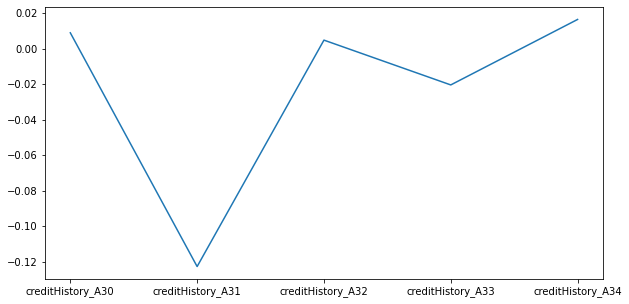

In [406]:
ale(model_fit, x, [s for s in x.columns if s.startswith('creditHistory')])

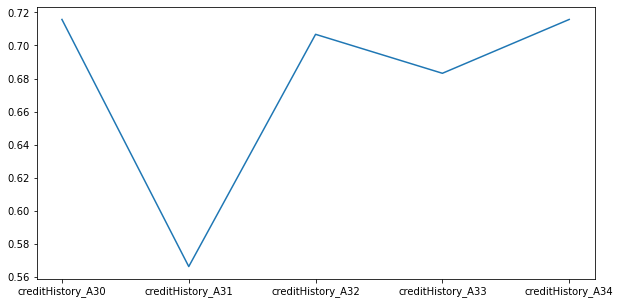

In [407]:
pdp(model_fit, x, [s for s in x.columns if s.startswith('creditHistory')])

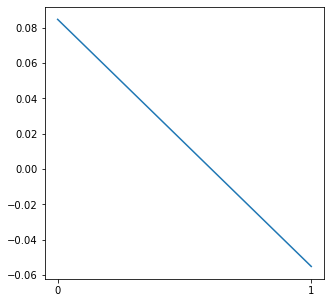

In [408]:
ale(model_fit, x, "accountStatus_1")

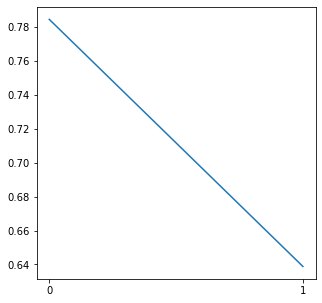

In [409]:
pdp(model_fit, x, "accountStatus_1")